# Recommender System using Collaborative Filtering

#### Implement a Movie Recommendation System and run it on the Movie Lens Dataset (Train vs Test). Mesure performance on test set using RMSE
- First you are required to compute first a user-user similarity based on ratings and movies in common
- Second, make rating predictions on the test set followoing the KNN idea: a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset as dataframe
movielens_fname = 'ml-100k/ml-100k/u.data'

movie_data = np.zeros((100000, 4))

with open(movielens_fname) as f:
    for ind, line in enumerate(f.readlines()):
        line = np.array([float(n) for n in line.strip().split('\t')])
        movie_data[ind] = line
        
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
movie_data_df = pd.DataFrame(movie_data,columns=col_names)

In [3]:
movie_data_df

,user_id,item_id,rating,timestamp
0,196.0,242.0,3.0,881250949.0
1,186.0,302.0,3.0,891717742.0
2,22.0,377.0,1.0,878887116.0
3,244.0,51.0,2.0,880606923.0
4,166.0,346.0,1.0,886397596.0
5,298.0,474.0,4.0,884182806.0
6,115.0,265.0,2.0,881171488.0
7,253.0,465.0,5.0,891628467.0
8,305.0,451.0,3.0,886324817.0
9,6.0,86.0,3.0,883603013.0


In [4]:
# Create utility matrix of size 943 x 1682

unique_users = movie_data_df.user_id.unique()
unique_movies = movie_data_df.item_id.unique()
utility_users = np.zeros((len(unique_users), len(unique_movies)))

for ind, r in movie_data_df.iterrows():
    utility_users[int(r['user_id']) - 1,int(r['item_id']) - 1] = float(r['rating'])

# Create user-user similarity matrix with pearsons as the similarity metric
similarity_users = np.corrcoef(utility_users)

In [5]:
similarity_users

array([[ 1.        ,  0.10632193, -0.01642393, ...,  0.1155035 ,
         0.10898367,  0.32323078],
       [ 0.10632193,  1.        ,  0.08268017, ...,  0.14417664,
         0.13829245,  0.05423526],
       [-0.01642393,  0.08268017,  1.        , ...,  0.08453195,
         0.10202478, -0.02360053],
       ...,
       [ 0.1155035 ,  0.14417664,  0.08453195, ...,  1.        ,
         0.08012962,  0.06529963],
       [ 0.10898367,  0.13829245,  0.10202478, ...,  0.08012962,
         1.        ,  0.12773543],
       [ 0.32323078,  0.05423526, -0.02360053, ...,  0.06529963,
         0.12773543,  1.        ]])

## Prediction and evaluation

In [6]:
# Get test set of 20% of users 

test_users = np.random.randint(similarity_users.shape[0], size = int(np.round(np.round(0.2 * 943))))

In [20]:
# Create list of average RMSE's over all test data for different values of K

all_ks = [1,2,3,4,5] + list(np.arange(6,52,3))[1:]
def get_predictions(utility_users, similarity_users, test_users):
    all_rmse_for_ks = []
    for temp_k in all_ks:

        all_rmse = []
        top_k_all = np.argsort(-similarity_users[test_users])[:,1:temp_k+1]
#         print('TOPKALL IS:', top_k_all)
        for i,sim in enumerate(top_k_all):
            temp_pred = np.mean(utility_users[sim], axis = 0)
#             print(temp_pred)
            all_rmse.append(np.sqrt(mean_squared_error(utility_users[test_users[i]], temp_pred)))
        all_rmse_for_ks.append(np.mean(all_rmse))
        
    return all_rmse_for_ks
    #     print('FOR K:',temp_k, 'RMSE IS:', all_rmse_for_ks)

In [21]:
rmse_vs_k = get_predictions(utility_users, similarity_users, test_users)

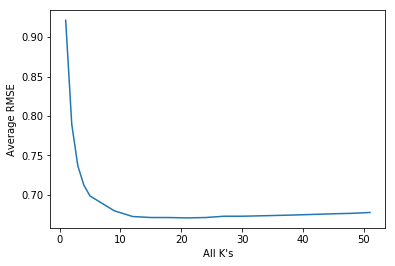

In [22]:
plt.plot(all_ks, rmse_vs_k)
plt.xlabel("All K's")
plt.ylabel('Average RMSE')
plt.show()